In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# transparentai package : https://github.com/Nathanlauga/transparentai
from transparentai.datasets import StructuredDataset, load_adult
from transparentai.fairness import DatasetBiasMetric, ModelBiasMetric
from transparentai.models import ClassificationModel
from transparentai.utils import encode_categorical_vars

# transparentai.__SAVEPLOT__ = True

In [2]:
adult = load_adult()
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

In [3]:
adult.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,age category
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,Young


In [13]:
dataset = StructuredDataset(df=adult,
                           target='income'
                          )

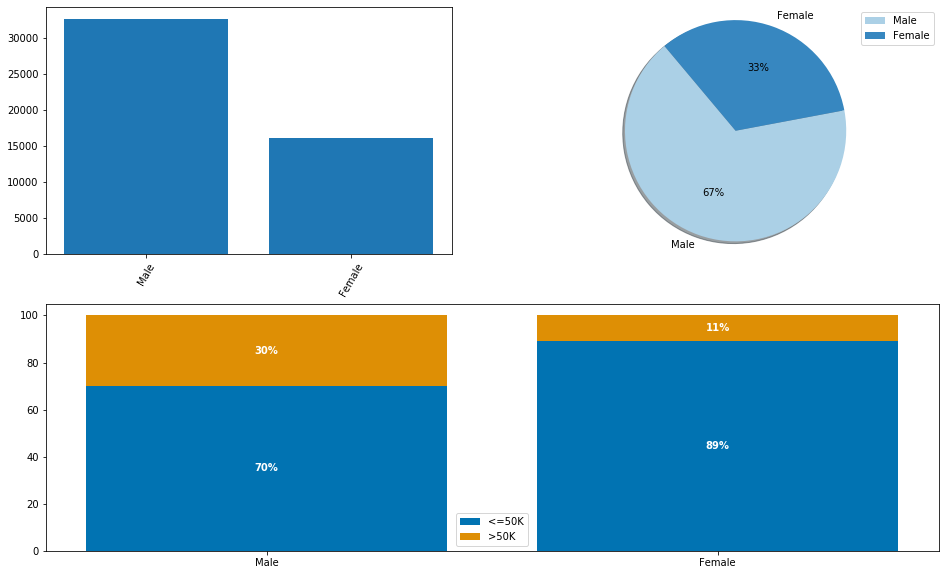

In [14]:
dataset.plot_cat_variable(var='gender')

In [15]:
privileged_groups = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}
dataset_bias = DatasetBiasMetric(dataset=dataset,
                                 privileged_groups=privileged_groups)

In [16]:
dataset_bias.get_bias_metrics(attr='gender')

,Disparate impact,Statistical parity difference
<=50K,1.279383,0.194516
>50K,0.359655,-0.194516


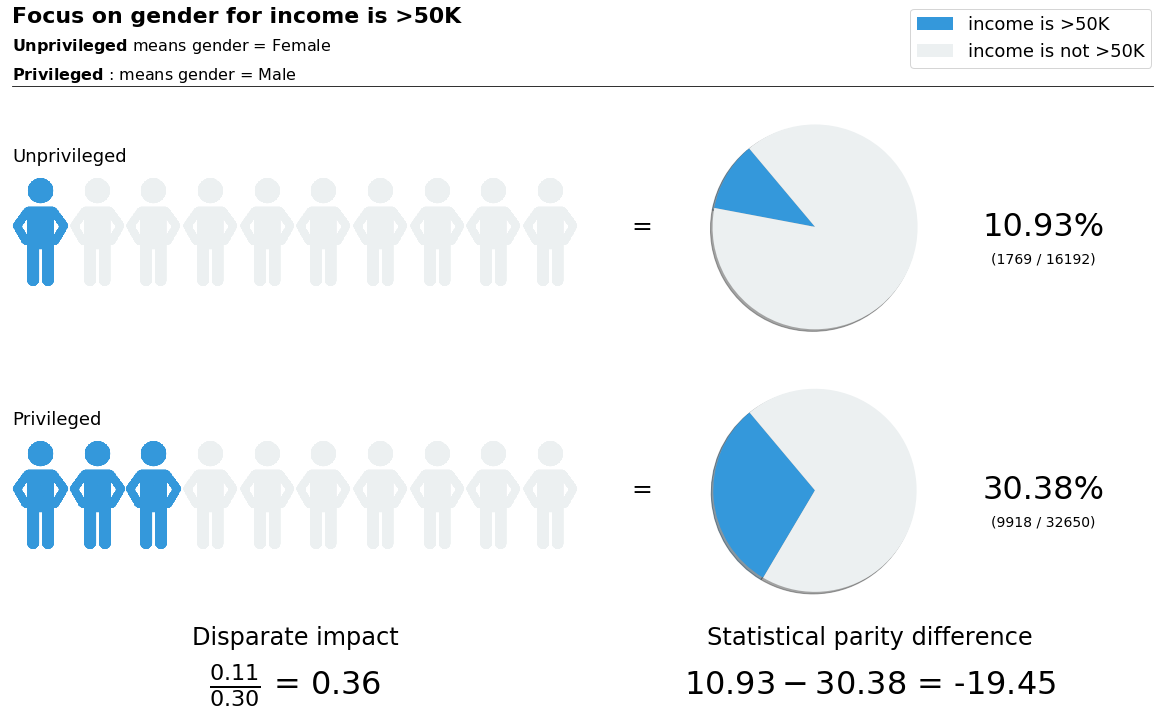

In [17]:
dataset_bias.plot_bias(attr='gender', target_value='>50K')

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# transparentai package : https://github.com/Nathanlauga/transparentai
from transparentai.datasets import StructuredDataset, load_adult
from transparentai.fairness import DatasetBiasMetric, ModelBiasMetric
from transparentai.models import ClassificationModel
from transparentai.utils import encode_categorical_vars

# transparentai.__SAVEPLOT__ = True
adult = load_adult()
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

In [2]:
target = 'income'
target_value = {'>50K':1, '<=50K':0}
adult[target] = adult[target].replace(target_value)
adult, encoders = encode_categorical_vars(adult)
X, y = adult.drop(columns=target), adult[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Overall model performance

,accuracy,f1,precision,recall,roc_auc
score,0.864313,0.864313,0.864313,0.864313,[0.9104387547348203]


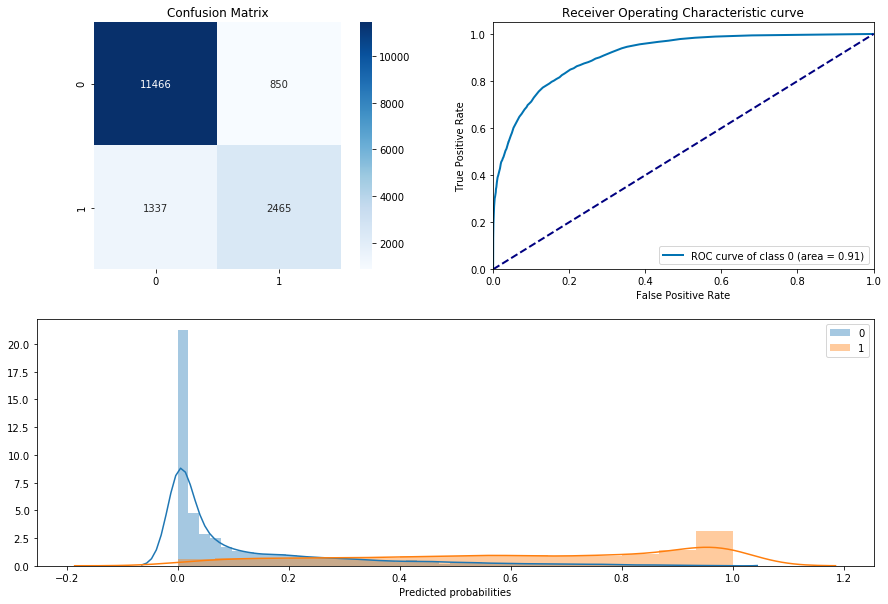

In [3]:
model = ClassificationModel(model=clf)
model.compute_scores(X=X_test, y=y_test, threshold=0.5)
model.plot_scores()

## Proba threshold comparison for accuracy, f1 score, precision & recall

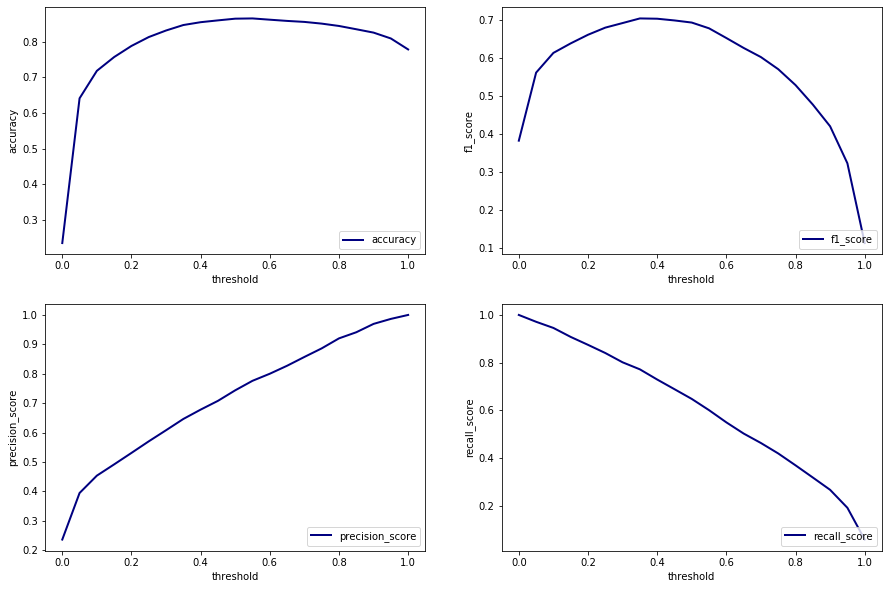

In [4]:
model.plot_threshold()

In [3]:
target = 'income'
df = X_test.copy()

for feature, encoder in encoders.items():
    df[feature] = encoder.inverse_transform(df[feature])

target_value = {0:'<=50K', 1:'>50K'}
df[target] = y_test.replace(target_value)

dataset = StructuredDataset(df=df, target=target)
preds = pd.Series(clf.predict(X_test)).replace(target_value)
privileged_groups = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}

In [4]:
model_bias = ModelBiasMetric(dataset=dataset,
                             preds=preds,
                             privileged_groups=privileged_groups)

In [5]:
model_bias.get_bias_metrics(attr='gender')

,Disparate impact,Statistical parity difference,Equal opportunity difference,Average abs odds difference,Theil index
<=50K,1.245056,0.545677,0.171491,0.169141,0.210303
>50K,0.301899,-0.548563,-0.166791,0.169141,0.255038


In [6]:
from random import random 

def generate_third_class(y):
    for i in range(0, int(len(y) / 10)):
        idx = int(random()*len(y))
        y.iloc[idx] = 2
    return y

y_test2 = y_test.copy()
preds2 = pd.Series(clf.predict(X_test))
y_test2 = generate_third_class(y_test2)
preds2 = generate_third_class(preds2)

In [7]:
target = 'income'
df = X_test.copy()

for feature, encoder in encoders.items():
    df[feature] = encoder.inverse_transform(df[feature])

# target_value = {0:'<=50K', 1:'>50K'}
df[target] = y_test2

dataset = StructuredDataset(df=df, target=target)
preds = preds2
privileged_groups = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}

In [8]:
model_bias = ModelBiasMetric(dataset=dataset,
                             preds=preds,
                             privileged_groups=privileged_groups)

In [9]:
model_bias.get_bias_metrics(attr='gender')

,Disparate impact,Statistical parity difference,Equal opportunity difference,Average abs odds difference,Theil index
0,1.243309,0.489126,0.156963,0.161281,0.261865
1,0.304511,-0.499047,-0.157608,0.154777,0.232385
2,1.024710,0.007034,-0.017439,0.011397,0.118927


No missing value.

### Numerical variables

**age :** 0 nulls, 71 unique vals, most common: {23: 476, 36: 451}

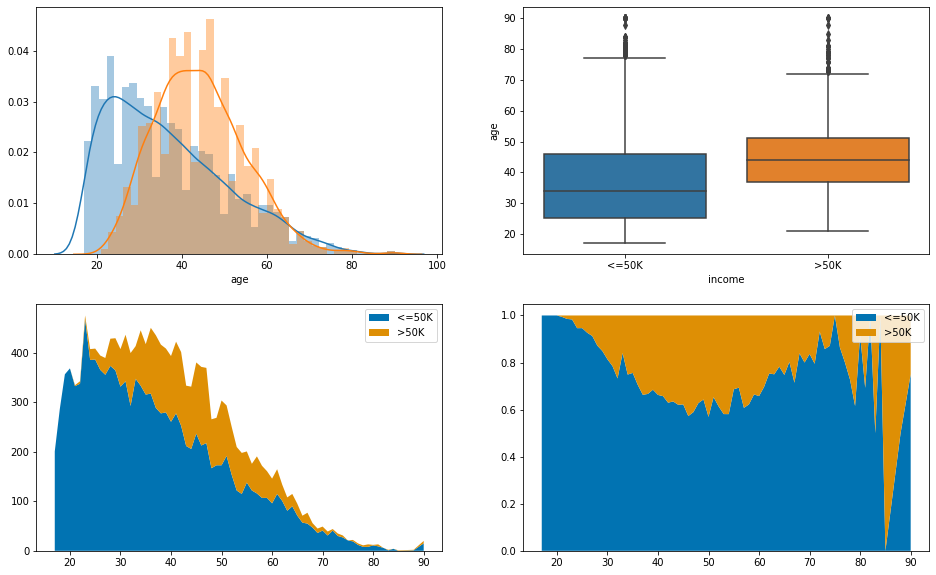

**fnlwgt :** 0 nulls, 12701 unique vals, most common: {120277: 10, 203488: 10}

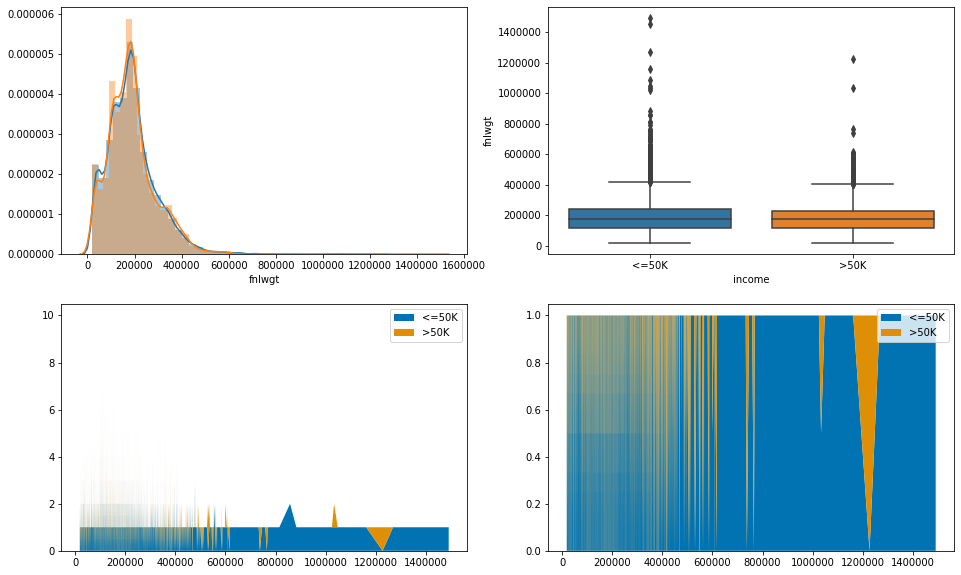

**education-num :** 0 nulls, 16 unique vals, most common: {9: 5237, 10: 3515}

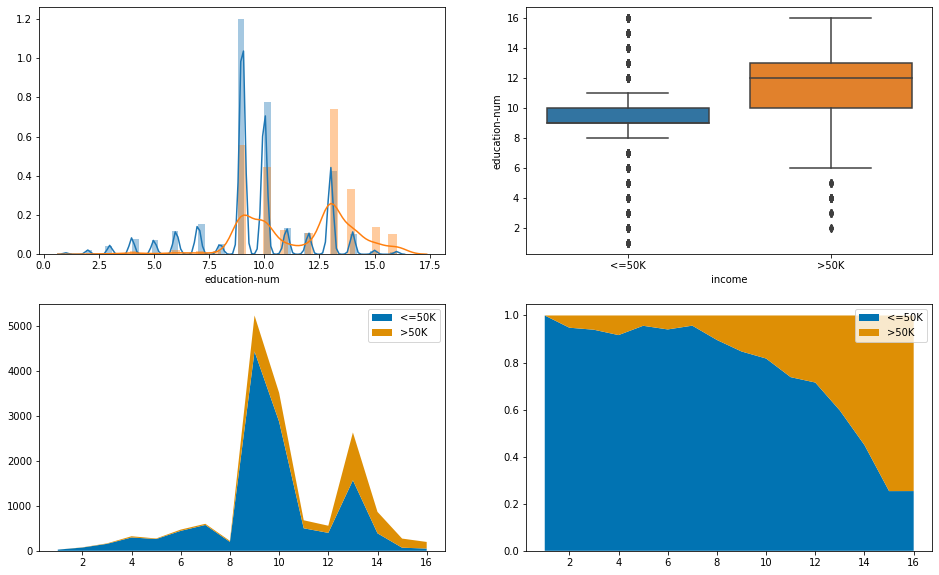

**capital-gain :** 0 nulls, 109 unique vals, most common: {0: 14777, 15024: 177}

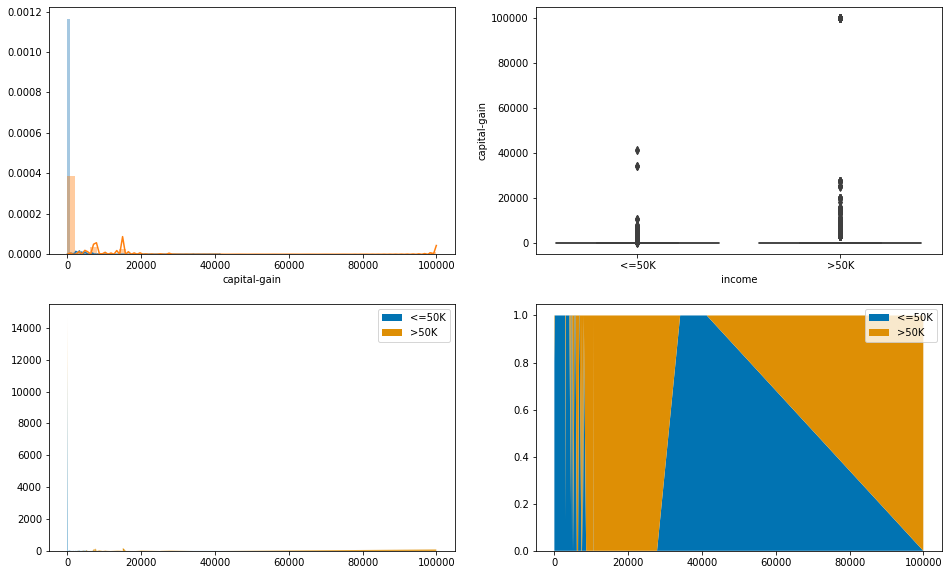

**capital-loss :** 0 nulls, 84 unique vals, most common: {0: 15406, 1902: 98}

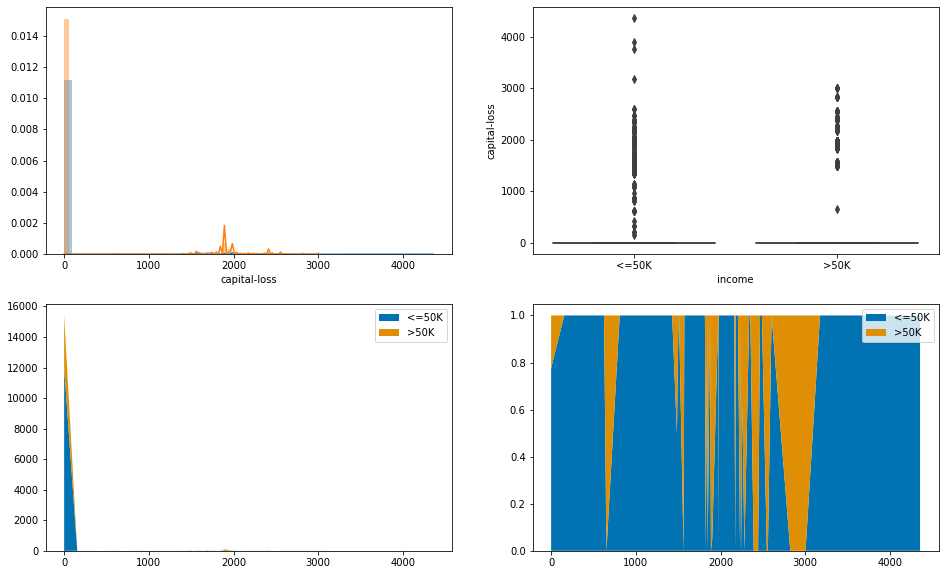

**hours-per-week :** 0 nulls, 86 unique vals, most common: {40: 7534, 50: 1378}

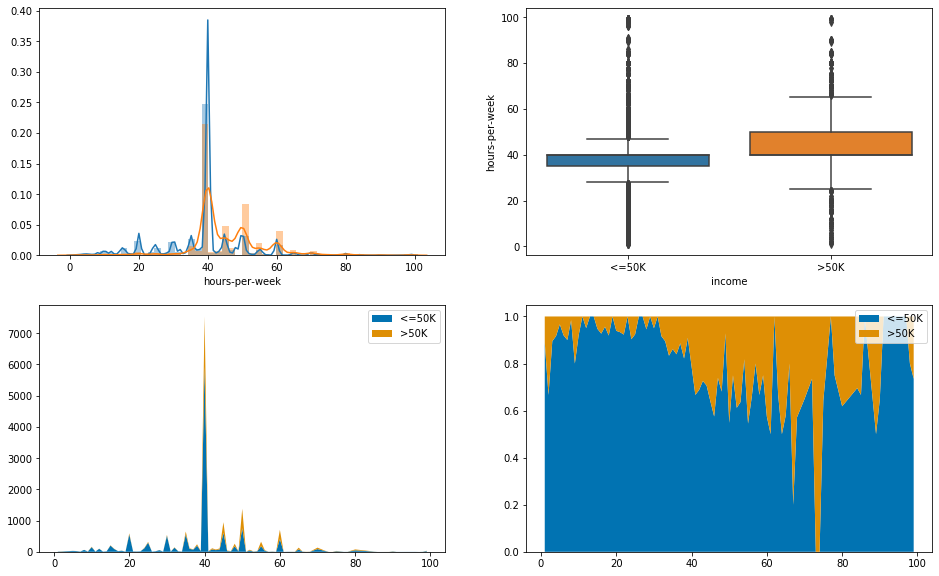

### Categorical variables

**workclass :** 0 nulls, 9 unique vals, most common: {'Private': 11239, 'Self-emp-not-inc': 1294}

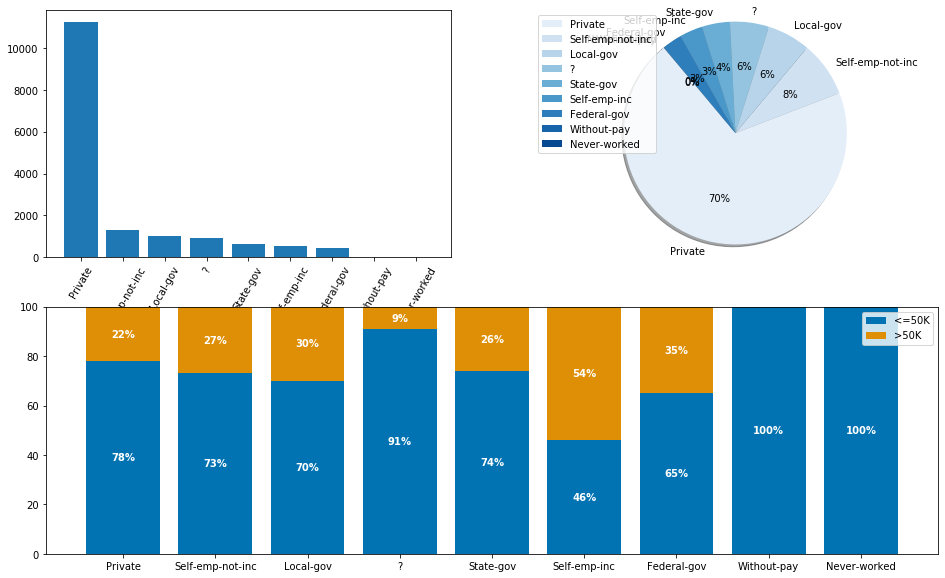

**education :** 0 nulls, 16 unique vals, most common: {'HS-grad': 5237, 'Some-college': 3515}

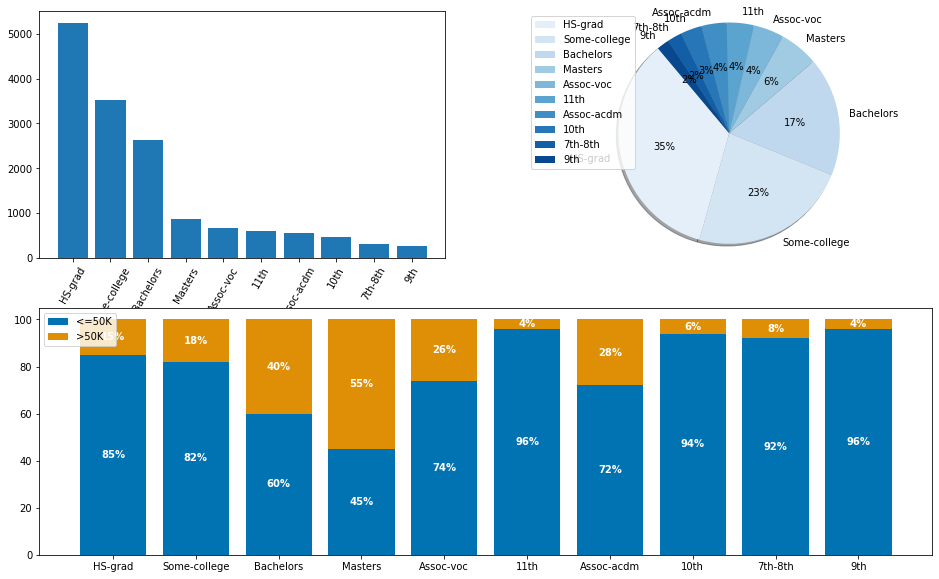

**marital-status :** 0 nulls, 7 unique vals, most common: {'Married-civ-spouse': 7268, 'Never-married': 5418}

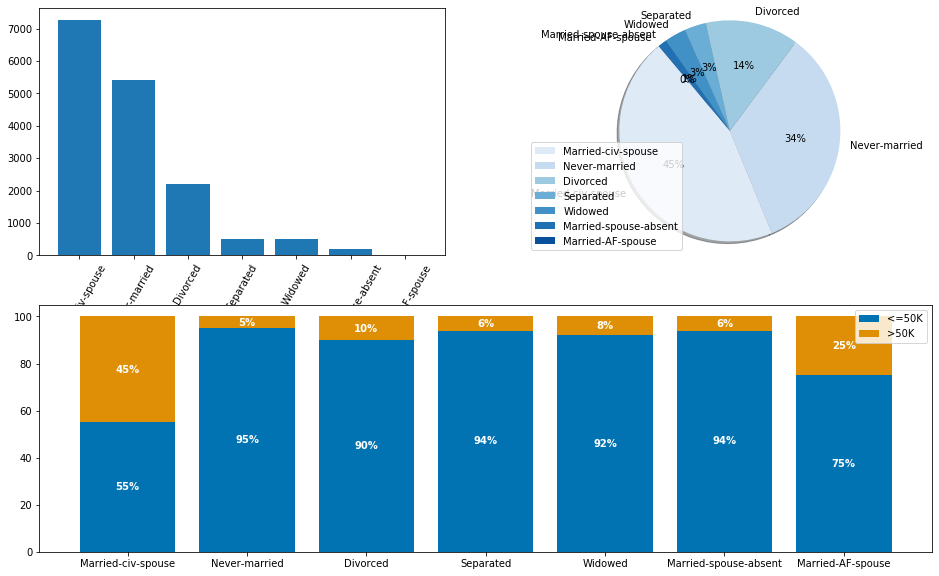

**occupation :** 0 nulls, 15 unique vals, most common: {'Craft-repair': 2025, 'Exec-managerial': 2015}

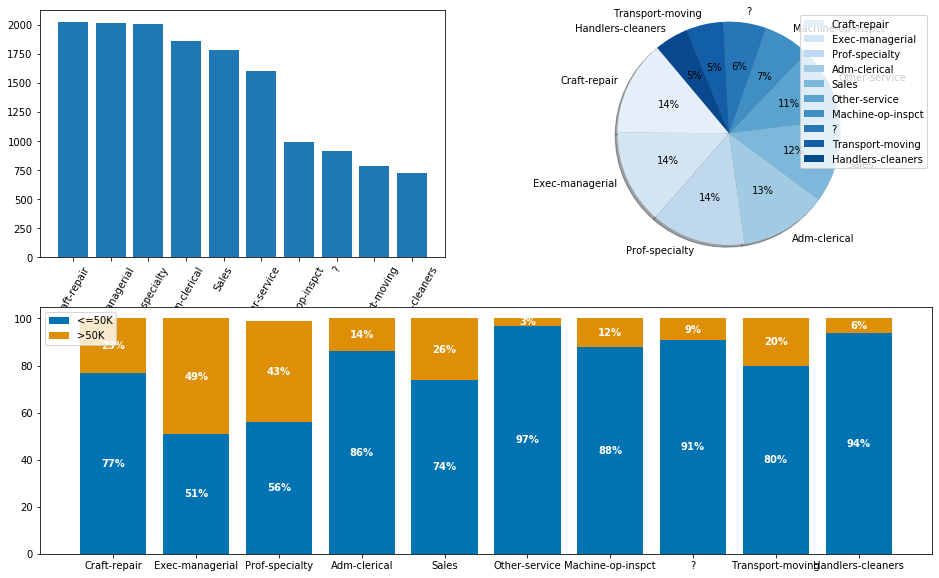

**relationship :** 0 nulls, 6 unique vals, most common: {'Husband': 6401, 'Not-in-family': 4178}

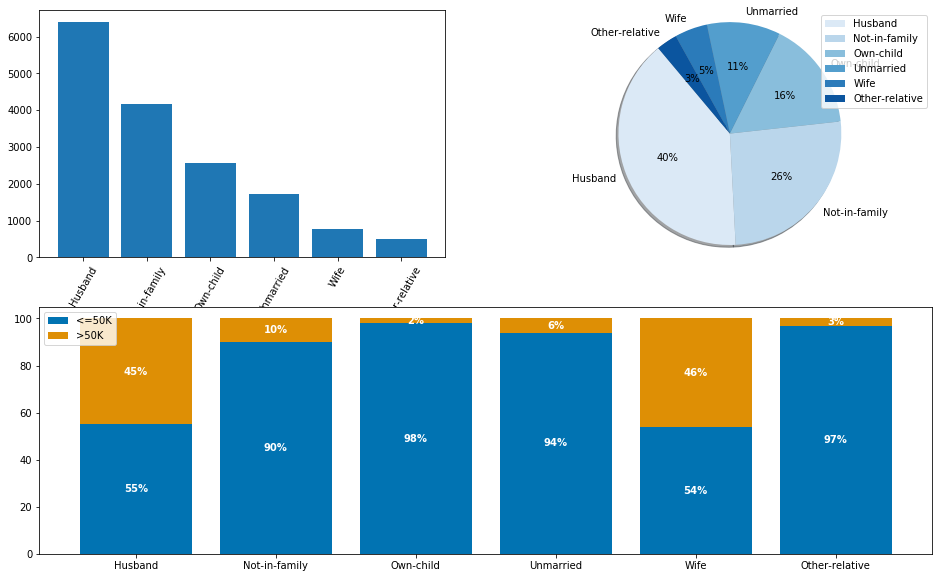

**race :** 0 nulls, 5 unique vals, most common: {'White': 13754, 'Black': 1600}

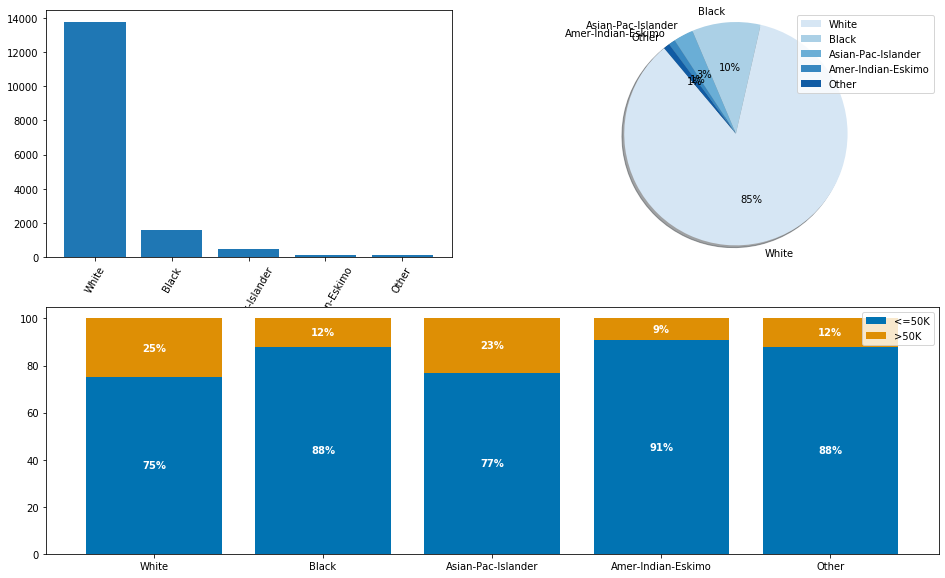

**gender :** 0 nulls, 2 unique vals, most common: {'Male': 10815, 'Female': 5303}

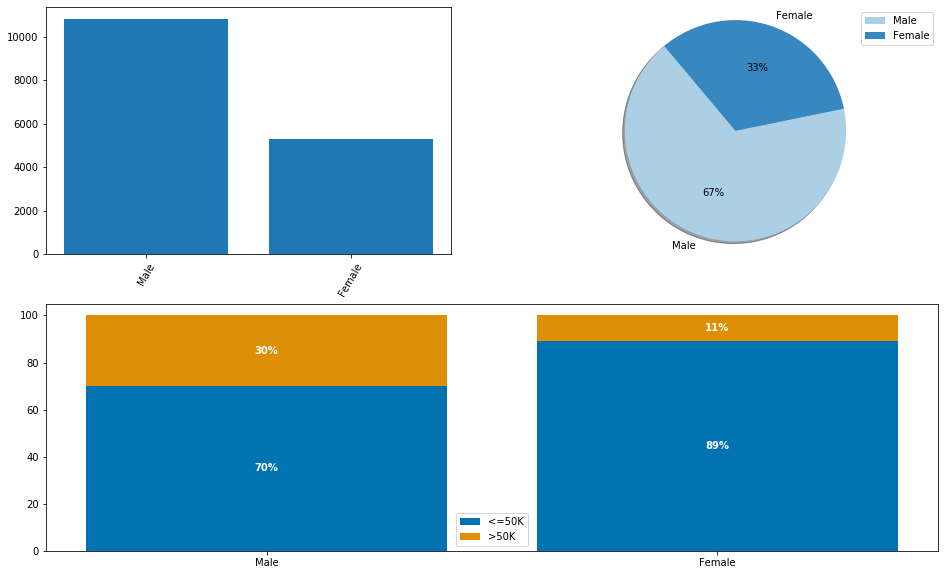

**native-country :** 0 nulls, 41 unique vals, most common: {'United-States': 14487, 'Mexico': 305}

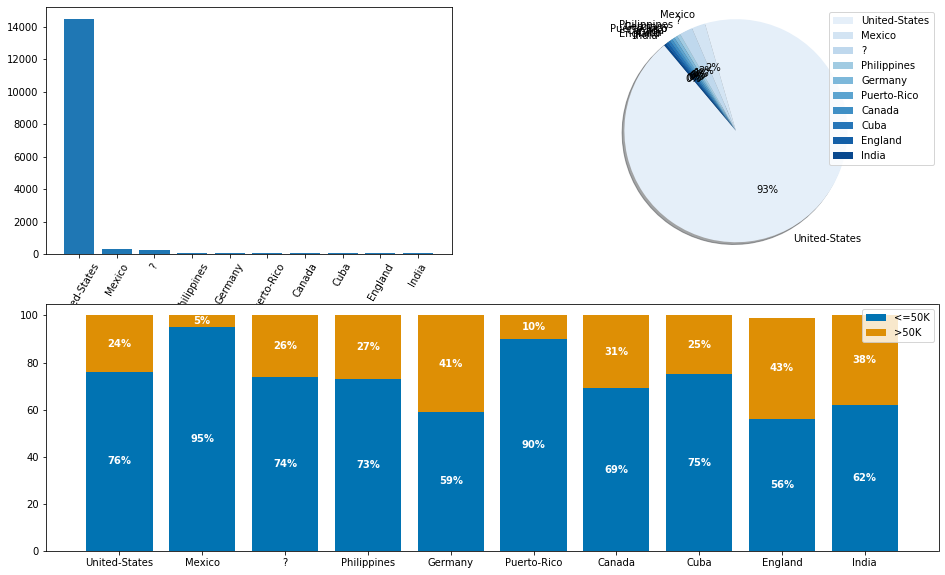

**age category :** 0 nulls, 3 unique vals, most common: {'Adult': 11727, 'Young': 3185}

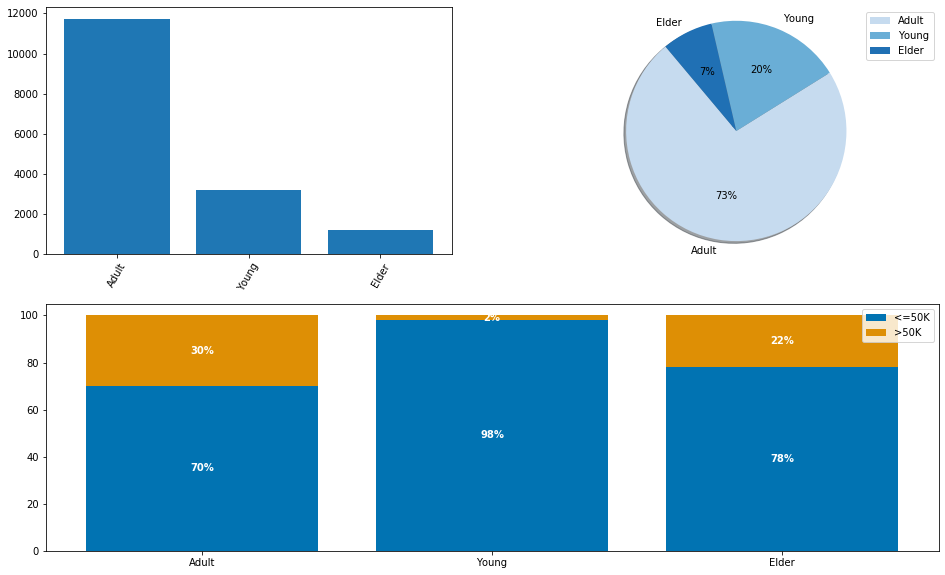

**income :** 0 nulls, 2 unique vals, most common: {'<=50K': 12316, '>50K': 3802}

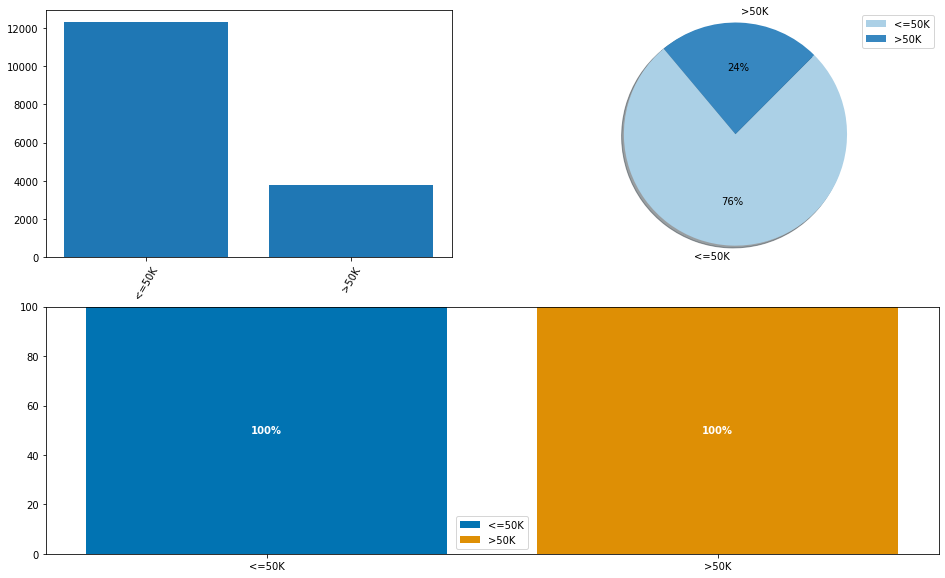

### Datetime variables

ValueError: The variable was not found inside the columns data

In [17]:
# Understand my data
dataset.plot_missing_values()

dataset.plot_variables()
dataset.plot_num_variable(var='var')
dataset.plot_cat_variable(var='var')
dataset.plot_datetime_variable(var='var')

dataset.plot_variables_scatter()
dataset.plot_scatter_two_variables(var1='var1', var2='var2')

dataset.plot_variables_boxplot()
dataset.plot_boxplot_two_variables(cat_var='cat_var', num_var='num_var')

dataset.plot_correlations()

# show bias
dataset_bias = DatasetBiasMetric(dataset=dataset,
                                 privileged_groups=privileged_groups)
dataset_bias.get_bias_metrics(attr='attr')

dataset_bias.plot_bias(attr='attr', target_value='1')
dataset_bias.display_insight(attr='attr', target_value='1')


# Model
model = ClassificationModel(model=clf)
model.compute_scores(X=X_test, y=y_test, threshold=0.5)
model.plot_scores()
model.plot_threshold()

# show bias
